In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(base_path, output_dir, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15):
    """
    Splits the dataset into training, validation, and test sets.
    
    Args:
        base_path (str): Path to the dataset with subfolders for each class.
        output_dir (str): Path to save the split datasets (train, valid, test).
        train_ratio (float): Proportion of data for training.
        valid_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create train, validation, and test directories
    train_dir = os.path.join(output_dir, 'Train')
    valid_dir = os.path.join(output_dir, 'Valid')
    test_dir = os.path.join(output_dir, 'Test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Iterate over each class folder
    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Get all image files in the class folder
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                  if os.path.isfile(os.path.join(class_path, img))]
        
        # Split the images into train, validation, and test sets
        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + valid_ratio)), random_state=42)
        
        # Create class subdirectories in train, valid, and test folders
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)
        
        # Copy files to respective directories
        for img in train_imgs:
            shutil.copy(img, os.path.join(train_dir, class_folder))
        for img in valid_imgs:
            shutil.copy(img, os.path.join(valid_dir, class_folder))
        for img in test_imgs:
            shutil.copy(img, os.path.join(test_dir, class_folder))

    print("Dataset successfully split into train, valid, and test sets.")

# Specify paths and call the function
base_path = "Revitsone-5classes"  # Replace with your dataset folder path
output_dir = "Output"  # Replace with the folder to save the split dataset
split_dataset(base_path, output_dir)


Dataset successfully split into train, valid, and test sets.


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define dataset paths
train_dir = 'Output/Train'
val_dir = 'Output/Valid'
test_dir = 'Output/Test'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(6, activation='softmax')(x)  # Final layer with 6 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model during initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Save the best model in HDF5 format
    monitor='val_loss',
    save_best_only=True
)


# Train the model with EarlyStopping and ModelCheckpoint
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model with EarlyStopping and ModelCheckpoint
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


Found 9109 images belonging to 6 classes.
Found 1951 images belonging to 6 classes.
Found 1957 images belonging to 6 classes.
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.4534 - loss: 1.3872 - val_accuracy: 0.7371 - val_loss: 0.7466
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 763s 3s/step - accuracy: 0.6613 - loss: 0.8756 - val_accuracy: 0.7960 - val_loss: 0.6136
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 724s 3s/step - accuracy: 0.7096 - loss: 0.7711 - val_accuracy: 0.8268 - val_loss: 0.5479
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1067s 4s/step - accuracy: 0.7158 - loss: 0.7312 - val_accuracy: 0.8273 - val_loss: 0.5090
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 753s 3s/step - accuracy: 0.7353 - loss: 0.6798 - val_accuracy: 0.8339 - val_loss: 0.4503
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.7485 - loss: 0.6414 - val_accuracy: 0.8432 - val_loss: 0.4322
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 715s 3s/step - accuracy: 0.7586 - loss: 0.6341 - val_accura

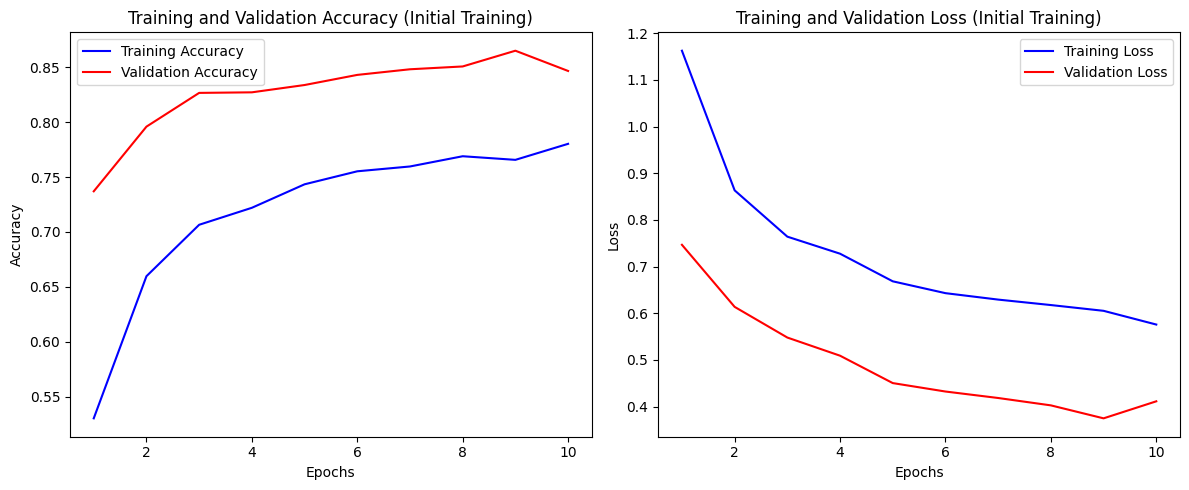

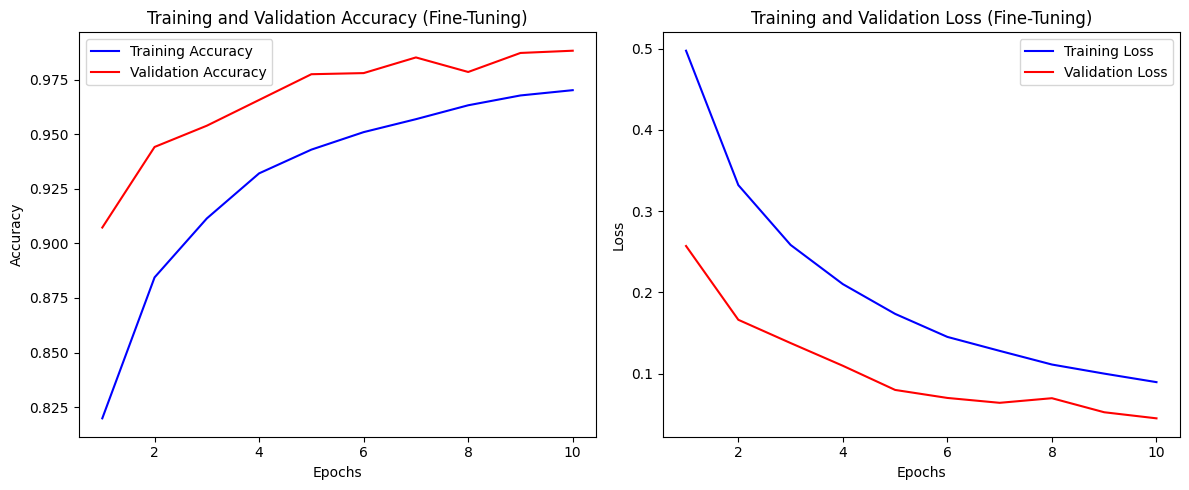

In [25]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_training_history(history, title_suffix="Initial Training"):
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy ({title_suffix})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss ({title_suffix})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot initial training history
plot_training_history(history, title_suffix="Initial Training")

# Plot fine-tuning training history
plot_training_history(history_fine_tune, title_suffix="Fine-Tuning")


In [26]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, 246, 246,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 60, 60,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 60, 60,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 60, 60,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 60, 60,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 60, 60,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 60, 60,    │     12,288 │ conv2_block2_0_r

 Total params: 9,980,628 (38.07 MB)

 Trainable params: 1,339,590 (5.11 MB)

 Non-trainable params: 5,961,856 (22.74 MB)

 Optimizer params: 2,679,182 (10.22 MB)

In [2]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Path to your test dataset
test_dir = 'Output/Test'  # Replace with the path to your 'test' folder

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='int',  # Class indices
    shuffle=False,  # Ensure order for correct metric computation
    image_size=(240, 240),  # Replace with your model's input size
    batch_size=32  # Adjust as per your memory capacity
)

# Extract images and labels
X_test = []
y_test = []

for images, labels in test_dataset:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize image data (if your models require this)
X_test = X_test / 255.0  # Assuming pixel values are [0, 255]

# Load models
model1 = load_model('best_model.keras')

# Get predictions for both models
y_pred1 = np.argmax(model1.predict(X_test), axis=1)
# y_pred2 = np.argmax(model2.predict(X_test), axis=1)

# Compute metrics for model1
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1, average='weighted')
recall1 = recall_score(y_test, y_pred1, average='weighted')
f1_score1 = f1_score(y_test, y_pred1, average='weighted')

# Print comparison
print("DenseNet121 Performance:")
print(f"Accuracy: {accuracy1:.4f}, Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1 Score: {f1_score1:.4f}")

# Optionally, show a detailed classification report for each model
print("\nClassification Report for DenseNet121:") #Densenet121
print(classification_report(y_test, y_pred1))

Found 1957 files belonging to 6 classes.


2024-12-01 22:31:33.978411: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step
DenseNet121 Performance:
Accuracy: 0.9842, Precision: 0.9843, Recall: 0.9842, F1 Score: 0.9842

Classification Report for DenseNet121:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       316
           1       0.99      0.97      0.98       331
           2       1.00      1.00      1.00       344
           3       0.98      0.98      0.98       326
           4       0.99      0.99      0.99       331
           5       0.98      0.99      0.99       309

    accuracy                           0.98      1957
   macro avg       0.98      0.98      0.98      1957
weighted avg       0.98      0.98      0.98      1957



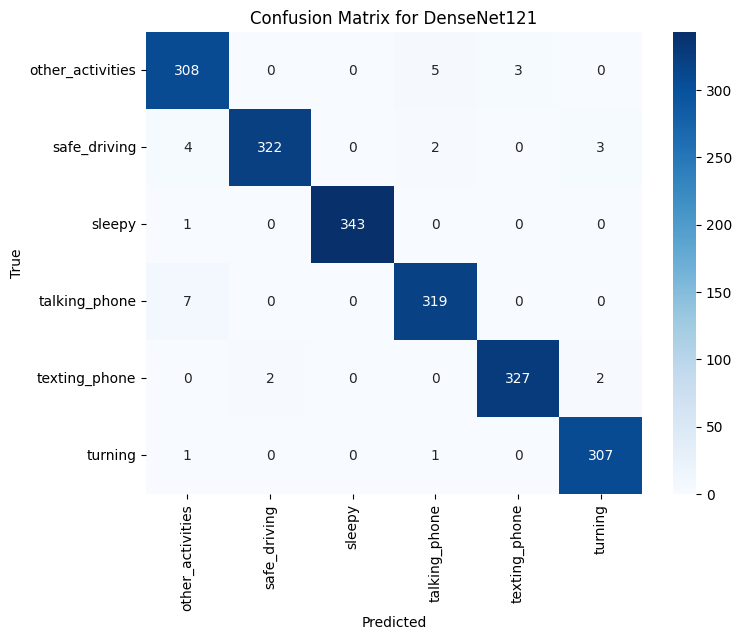

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DenseNet121')
plt.show()
